In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from astral import Astral, AstralGeocoder, Location

import statsmodels.api as sm

from calculations import *
from plotting import *

from patsy import dmatrix


 
import datetime 
%matplotlib inline

In [2]:
phil_stops = pd.read_csv('data/philadelpha_stops.csv')

In [3]:
phil_stops.head()

,raw_row_number,date,time,location,lat,lng,district,service_area,subject_age,subject_race,subject_sex,type,arrest_made,outcome,contraband_found,frisk_performed,search_conducted,search_person,search_vehicle
0,1,2014-09-27,20:05:00,5600 BLOCK BROOMALL ST,39.943742,-75.232790,12.0,124.0,24.0,black,male,pedestrian,False,NaN,NaN,False,False,False,False
1,2,2014-09-27,19:27:00,5200 BLOCK PENTRIDGE ST,39.945217,-75.224756,12.0,124.0,58.0,black,male,pedestrian,False,NaN,NaN,False,False,False,False
2,3,2014-09-27,19:27:00,5200 BLOCK PENTRIDGE ST,39.945217,-75.224756,12.0,124.0,31.0,black,male,pedestrian,False,NaN,NaN,False,False,False,False
3,4,2014-09-27,20:38:00,4900 BLOCK KINGSESSING AV,39.943045,-75.215211,12.0,123.0,29.0,black,male,vehicular,False,NaN,NaN,False,False,False,False
4,5,2014-10-24,03:00:00,1800 BLOCK WALNUT ST,39.950203,-75.171467,9.0,92.0,35.0,black,male,pedestrian,False,NaN,NaN,False,False,False,False


In [4]:
phil_stops.columns

Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle'],
      dtype='object')

In [5]:
len(phil_stops)

1891916

In [6]:
phil_stops['date'] = pd.to_datetime(phil_stops['date'])

In [7]:
phil_stops['date'].min()

Timestamp('2014-01-01 00:00:00')

In [8]:
phil_stops['date'].max()

Timestamp('2018-04-14 00:00:00')

In [9]:
get_year = lambda date: date.year
phil_stops['year'] = phil_stops['date'].apply(get_year)
phil_stops = phil_stops[(phil_stops['year'] >= 2014) & (phil_stops['year'] <= 2017)]

In [10]:
(phil_stops['date'].min(), phil_stops['date'].max(), len(phil_stops))

(Timestamp('2014-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'), 1782092)

In [11]:
phil_stops['type'].head(10)

0    pedestrian
1    pedestrian
2    pedestrian
3     vehicular
4    pedestrian
5    pedestrian
6     vehicular
7    pedestrian
8    pedestrian
9     vehicular
Name: type, dtype: object

In [12]:
phil_stops = phil_stops[phil_stops['type'] == 'vehicular']
len(phil_stops)

1090441

In [13]:
phil_stops.groupby('year').size()

year
2014    219071
2015    285914
2016    288306
2017    297150
dtype: int64

In [14]:
calc_group_size(phil_stops, ['subject_race'])

,subject_race,n,prop
0,asian/pacific islander,31197,0.028610
1,black,714772,0.655489
2,hispanic,112950,0.103582
3,other/unknown,15109,0.013856
4,white,216413,0.198464


In [15]:
groupby_year_and_race = calc_group_size(phil_stops, ['year', 'subject_race'])
groupby_year_and_race

,year,subject_race,n,prop
0,2014,asian/pacific islander,7317,0.006710
1,2014,black,134192,0.123062
2,2014,hispanic,23036,0.021125
3,2014,other/unknown,2631,0.002413
4,2014,white,51895,0.047591
5,2015,asian/pacific islander,8613,0.007899
6,2015,black,183067,0.167883
7,2015,hispanic,30105,0.027608
8,2015,other/unknown,3793,0.003478
9,2015,white,60336,0.055332


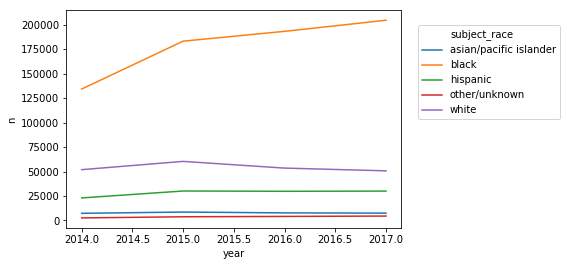

In [16]:
ax = sns.lineplot(x = 'year', y = 'n', hue = 'subject_race', data = groupby_year_and_race);
ax.legend(loc = (1.05, 0.5));

In [17]:
population_df = pd.DataFrame({'asian/pacific islander': 110864, 'black': 648846, 'hispanic': 221777, 'other/unknown': 39858,
                'white': 548312}.items())
population_df.columns = ['subject_race', 'num_people']
population_df

,subject_race,num_people
0,asian/pacific islander,110864
1,black,648846
2,hispanic,221777
3,other/unknown,39858
4,white,548312


In [18]:
phil_stops_2017 = phil_stops[phil_stops['year'] == 2017]

In [19]:
calc_stop_rates(phil_stops_2017, population_df, ['subject_race'])

,subject_race,stop_rate
0,asian/pacific islander,0.067687
1,black,0.315052
2,hispanic,0.135267
3,other/unknown,0.113628
4,white,0.092462


In [20]:
calc_search_rates(phil_stops_2017, ['subject_race'])

,subject_race,search_rate
0,asian/pacific islander,0.026119
1,black,0.060547
2,hispanic,0.051002
3,other/unknown,0.036873
4,white,0.040968


In [21]:
calc_frisk_rates(phil_stops_2017, ['subject_race'])

,subject_race,frisk_rate
0,asian/pacific islander,0.018790
1,black,0.063624
2,hispanic,0.047102
3,other/unknown,0.034003
4,white,0.030593


In [22]:
phil_stops_2017['contraband_found'] = phil_stops_2017['contraband_found'].astype(float)
calc_hit_rates(phil_stops_2017, ['subject_race'])

/anaconda3/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,subject_race,hit_rate
0,asian/pacific islander,0.244898
1,black,0.219520
2,hispanic,0.200654
3,other/unknown,0.173653
4,white,0.247472


In [23]:
hit_rates = calc_hit_rates(phil_stops_2017, groupby_cols = ['subject_race', 'district'])
hit_rates.head()

,subject_race,district,hit_rate
0,asian/pacific islander,1.0,0.166667
1,asian/pacific islander,2.0,0.500000
2,asian/pacific islander,3.0,0.400000
3,asian/pacific islander,6.0,0.333333
4,asian/pacific islander,7.0,0.000000


In [24]:
hit_rates_comparison = compare_rates('hit_rate', hit_rates, 'white', ['black', 'hispanic'], 'subject_race')
hit_rates_comparison.head()

,district,white_hit_rate,minority_group,minority_hit_rate
0,1.0,0.611111,black,0.185841
1,1.0,0.611111,hispanic,0.500000
2,2.0,0.363636,black,0.343915
3,2.0,0.363636,hispanic,0.246914
4,3.0,0.413333,black,0.250000


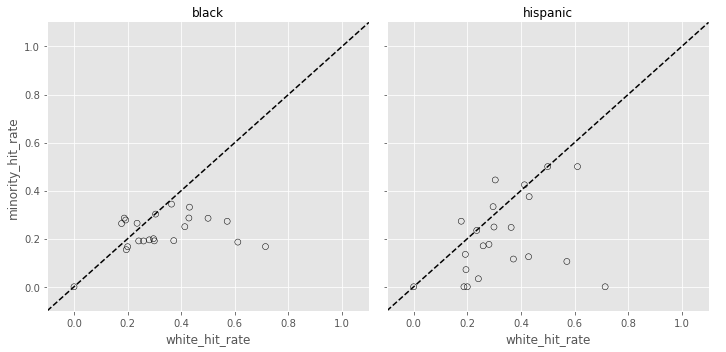

In [25]:
plot_rates_comparison('hit_rate', hit_rates_comparison, 'white', 'minority_group', None)

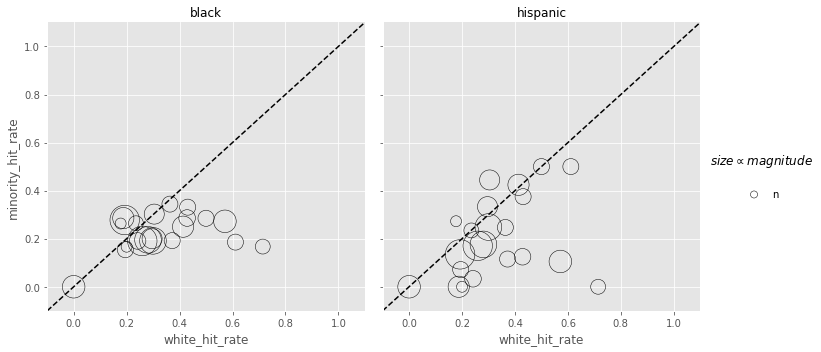

In [26]:
hit_rates_comparison_with_size = hit_rates_comparison.merge(calc_group_size(phil_stops, ['district'], False))
plot_rates_comparison('hit_rate', hit_rates_comparison_with_size, 'white', 'minority_group', 'n', marker_size_scale = 100)

In [27]:
sunset_times_2017 = calc_sunset_times(phil_stops_2017, 39.9525839, -75.1652215, 'US/Eastern')
sunset_times_2017[(sunset_times_2017['sunset'] == sunset_times_2017['sunset'].min()) | (sunset_times_2017['sunset'] == sunset_times_2017['sunset'].max())]

,date,sunset,dusk,sunset_minute,dusk_minute
145,2017-06-28,20:33:27,21:06:12,1233,1266
218,2017-12-08,16:35:22,17:05:39,995,1025


In [28]:
vod_stops = get_veil_of_darkness_observations(phil_stops_2017, sunset_times_2017)

In [29]:
vod_stops.head()

,raw_row_number,date,time,location,lat,lng,district,service_area,subject_age,subject_race,...,search_person,search_vehicle,year,sunset,dusk,sunset_minute,dusk_minute,minute,minutes_after_dark,is_dark
0,1025649,2017-03-22,20:30:00,NaN,NaN,NaN,25.0,252.0,39.0,white,...,False,False,2017,19:14:01,19:41:02,1154,1181,1230,49,1
4,1025656,2017-03-22,19:50:00,NaN,NaN,NaN,25.0,252.0,42.0,black,...,False,False,2017,19:14:01,19:41:02,1154,1181,1190,9,1
5,1025657,2017-03-22,21:05:00,NaN,NaN,NaN,25.0,251.0,81.0,white,...,False,False,2017,19:14:01,19:41:02,1154,1181,1265,84,1
7,1025668,2017-03-22,20:05:00,NaN,NaN,NaN,25.0,253.0,24.0,black,...,False,False,2017,19:14:01,19:41:02,1154,1181,1205,24,1
8,1025669,2017-12-20,19:58:00,1000 BLOCK E HORTTER ST,40.065679,-75.170009,14.0,141.0,24.0,black,...,False,True,2017,16:38:03,17:08:36,998,1028,1198,170,1


In [30]:
vod_stops['time'] = vod_stops['time'].apply(lambda time: datetime.datetime.strptime(time, '%H:%M:%S').time())
calc_vod_rate(vod_stops, '18:30', '18:45', 'subject_race', time_col = 'time')


/Users/blin/Documents/ac221/project_clone/opp/calculations.py:331: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  vod_count = vod_stops.groupby('is_dark')[vod_stops.columns.values[0]].agg({'total_count': 'count'})


subject_race,asian/pacific islander,black,hispanic,other/unknown,white
is_dark,,,,,
0,0.020758,0.690080,0.125030,0.015448,0.148685
1,0.027970,0.643992,0.144682,0.016229,0.167127


In [31]:
is_black = (vod_stops['subject_race'] == 'black').astype(int)

X = vod_stops[['is_dark']].merge(dmatrix("cr(data,df = 6)", {"data": vod_stops['minute']}, return_type='dataframe'),
                                left_index = True, right_index = True)

logit_model = sm.GLM(is_black, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           subject_race   No. Observations:                95858
Model:                            GLM   Df Residuals:                    95851
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -58902.
Date:                Fri, 10 May 2019   Deviance:                   1.1780e+05
Time:                        09:11:31   Pearson chi2:                 9.59e+04
No. Iterations:                   100   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_dark              -0.1823      0.017    -11.009      0.000      -0.215      -0.150
Intercept             0.7720   

In [32]:
X = vod_stops[['is_dark']].merge(dmatrix("cr(data,df = 6)", {"data": vod_stops['minute']}, return_type='dataframe'),
                                left_index = True, right_index = True)

X = X.merge(pd.get_dummies(vod_stops['district']), left_index = True, right_index = True)
X = sm.add_constant(X)
# X
logit_model = sm.GLM(is_black, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

/anaconda3/envs/general/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


                 Generalized Linear Model Regression Results                  
Dep. Variable:           subject_race   No. Observations:                95858
Model:                            GLM   Df Residuals:                    95830
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43778.
Date:                Fri, 10 May 2019   Deviance:                       87556.
Time:                        09:11:39   Pearson chi2:                 9.58e+04
No. Iterations:                   100   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_dark              -0.1555      0.020     -7.775      0.000      -0.195      -0.116
Intercept             0.4903   